In [268]:
from astroplan import Observer
import astropy.units as u
from astropy.coordinates import EarthLocation
from astropy.coordinates import SkyCoord
from astropy.time import Time
from pytz import timezone
from astroplan import FixedTarget

# Location
First we set up the location for weather data and astrophotography calculations

In [269]:
latitude = 59.10486
longitude = 11.83123
msl = 30
elevation = msl * u.m
location = EarthLocation.from_geodetic(longitude, latitude, elevation)

observer = Observer(name = 'Stora Le',
                    location=location,
                    pressure = 1.013 * u.bar,
                    relative_humidity = 0.88,
                    temperature = -6 * u.deg_C,
                    timezone=timezone('Europe/Oslo'),
                    description="Custom dark location near Stora Le, Sweden")

# Target
Next, an observation target is defined. We'll give the variable an appropriate name (but have to hardcode this in further

In [270]:
HIP31159_coord = SkyCoord(ra=98.080018428*u.deg, dec=4.855997578*u.deg)
HIP31159 = FixedTarget(coord=HIP31159_coord, name="HIP 31159")
target = HIP31159

# Weather
Weather is fetched with the Norwegian Meteorological Society's API (fair use warning).

In [271]:
weatherURL = ("http://api.met.no/weatherapi/locationforecast/1.9/?" + 
              "lat=" + str(latitude) + 
              ";lon=" + str(longitude) +
              ";msl=" + str(msl)
             )

In [272]:
weatherURL

'http://api.met.no/weatherapi/locationforecast/1.9/?lat=59.10486;lon=11.83123;msl=30'

### datetime.parser
dateutil.parser is an amazing datetime parser. Just feed it a datetime string, it will figure out the formatting for you

In [273]:
import untangle
import pandas as pd
from dateutil import parser
obj = untangle.parse(weatherURL)

In [274]:
df = pd.DataFrame()
lst_from = []
lst_to = []
lst_lat = []
lst_lon = []
lst_cloudiness = []
lst_Rh = []
lst_temp = []
lst_prec = []
lst_pressure = []

In [275]:
for t in obj.weatherdata.product.time:
    lst_from.append(parser.parse(t['from']))
    lst_to.append(parser.parse(t['to']))
    
    for l in t.location:
        lst_lat.append(float(l['latitude']))
        lst_lon.append(float(l['longitude']))
        try:
            lst_cloudiness.append(float(l.cloudiness['percent']))
        except AttributeError:
            lst_cloudiness.append(float('NaN'))
        
        try:
            lst_Rh.append(float(l.humidity['value']))
        except AttributeError:
            lst_Rh.append(float('NaN'))
            
        try:
            lst_temp.append(float(l.temperature['value']))
        except AttributeError:
            lst_temp.append(float('NaN'))
            
        try:
            lst_prec.append(float(l.precipitation['value']))
        except AttributeError:
            lst_prec.append(float('NaN'))
            
        try:
            lst_pressure.append(float(l.pressure['value']))
        except AttributeError:
            lst_pressure.append(float('NaN'))

In [276]:
df['time_from'] = lst_from
df['to'] = lst_to
df['lat'] = lst_lat
df['lon'] = lst_lon
df['cloudiness'] = lst_cloudiness
df['humidity'] = lst_Rh
df['temperature'] = lst_temp
df['precipitation'] = lst_prec
df['pressure'] = lst_pressure

In [277]:
weather = df[df.humidity.notnull()][['time_from',
                                     'cloudiness',
                                     'humidity',
                                     'temperature',
                                     'pressure'
                                    ]]

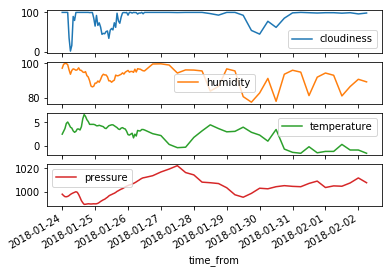

In [278]:
weather.plot('time_from', subplots=1)
plt.show()

In [279]:
lst_airmass = []
lst_moonalt = []
lst_moonillum = []

for i, row in weather.iterrows():
    time = row.time_from
    observer = Observer(name = 'Stora Le',
                    location=location,
                    pressure = row.pressure/1000 * u.bar,
                    relative_humidity = row.humidity,
                    temperature = row.temperature * u.deg_C,
                    timezone=timezone('Europe/Oslo'),
                    description="Custom dark location near Stora Le, Sweden")
    lst_airmass.append(float(observer.altaz(time, target).secz))
    lst_moonalt.append(float(observer.moon_altaz(time).alt.value))
    lst_moonillum.append(float(observer.moon_illumination(time)))

In [280]:
astroweather = weather
astroweather['airmass'] = lst_airmass
astroweather['moon altitude'] = lst_moonalt
astroweather['moon illumination'] = lst_moonillum

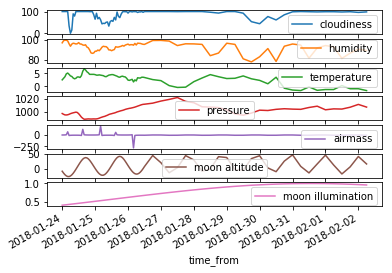

In [281]:
ax = astroweather.plot('time_from', subplots=1)

# Plotting
Plotting some relevant figures

array([<matplotlib.axes._subplots.AxesSubplot object at 0x000001C776A01550>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x000001C77A867438>], dtype=object)

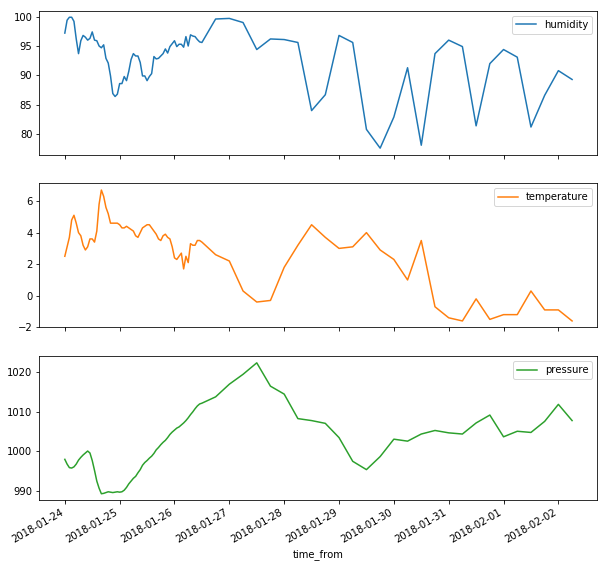

In [282]:
astroweather[['time_from','humidity','temperature','pressure']].\
    plot(
        x = 'time_from',
        subplots=1,
        figsize=(10,10))

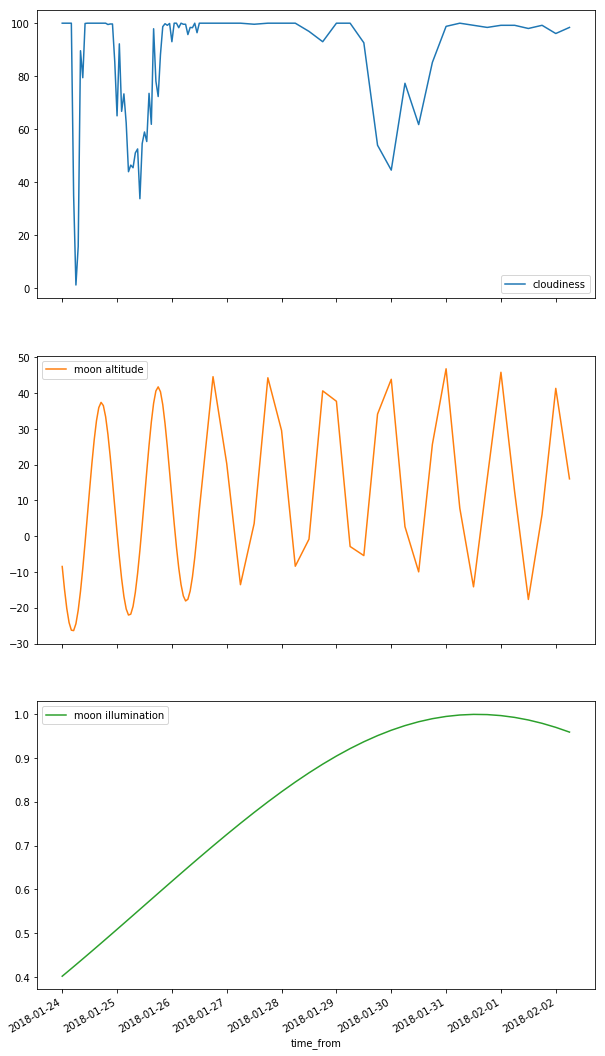

In [283]:
astroweather[['time_from','cloudiness','moon altitude','moon illumination']].\
    plot(
        x = 'time_from',
        subplots=1,
        figsize=(10,20))

plt.show()